In [17]:
from pymongo import MongoClient
from pathlib import Path
import os
from pprint import pprint
import nltk
import matplotlib.pyplot as plt
import pprint

In [18]:
client = MongoClient('mongodb://localhost:27017')
testDb = client.testDb

In [19]:
patients = testDb.patients
sessions = testDb.sessions
reports = testDb.reports

In [20]:
def fileName(filePath):
    return (os.path.splitext(os.path.split(filePath)[1]))[0]

def fileExt(filePath):
    try:
        return (os.path.splitext(os.path.split(filePath)[1]))[1]
    except:
        return "Error"

In [69]:
p1 = os.listdir("v1.2.0/eval")
print(p1)
print(os.path.isdir(p1[0]))
print(os.path.isfile(p1[1]))
pathString = ("/"+str(p1[0]))
print(pathString)
patientDict = {}
fileNames = []
maxFileSize = 0 
maxFileName = ""
for root,dirs,files in os.walk("v1.2.0"):
    #print ("root: ",root)
    #print("\tdirs: ",dirs)
    #print("\t\t",str(files))
        
    if len(files)>0:
        for file in files:
            fileNames.append(str(root)+"/"+str(file))
            if os.path.getsize((str(root)+"/"+file)) > maxFileSize:
                maxFileSize = os.path.getsize((str(root)+"/"+file))
                maxFileName = (str(root)+"/"+file)
            else:
                continue
            
            
        #print ("\t\tFile: "+files[3])
        
print (maxFileName," : ",maxFileSize)
print (os.path.splitext(maxFileName))
print (os.path.split(maxFileName))
print (os.path.splitext(os.path.split(maxFileName)[1]))
print (fileName(maxFileName))
print (fileExt(maxFileName))

['03_tcp_ar_a', '02_tcp_le', '.DS_Store', '01_tcp_ar']
False
False
/03_tcp_ar_a
v1.2.0/eval/01_tcp_ar/00001278/s002_2003_11_17/00001278_s002_t001.edf  :  67899648
('v1.2.0/eval/01_tcp_ar/00001278/s002_2003_11_17/00001278_s002_t001', '.edf')
('v1.2.0/eval/01_tcp_ar/00001278/s002_2003_11_17', '00001278_s002_t001.edf')
('00001278_s002_t001', '.edf')
00001278_s002_t001
.edf


In [109]:
def addFile(filepath):
    splitFile = filepath.split('/')
    if len(splitFile)<6:
        pass
        #print("File path too short")
    else:
        patientId = splitFile[3]
        currentFile = splitFile[5] #changed from 5 to 4
        currentSessionNumber = splitFile[4].split('_')[0]
        currentFileSplit = currentFile.split('_')
        currentFileExt = str(fileExt(currentFile))
        sessionNumber = currentFileSplit[0] #Changed from 1 to 0
        sessionId = str(patientId)+str(currentSessionNumber)
        #print("\tFile Path: ",filepath)
        #print("\t\tCurrentFile: ",currentFileSplit)
        #print("\t\tCurrentFileExt: ",currentFileExt)
        #print("\t\tSessionId: ",sessionId)
        dbSession = sessions.find_one({"sessionId":sessionId})
        
        if dbSession == None:
            sessions.insert_one({"sessionId":sessionId,"patientId":patientId})
            #print("Found a new session")
        else:
            pass
            #print("Found this session\n")  
        if currentFileExt == ".txt":
            try:
                with open(str(files),'r') as reportFile:
                    rText = reportFile.readlines()  
                try:
                    sessions.update_one({"sessionId":sessionId},
                                       {"$set":{"reportText":rText}})
                except:
                    pass
                    #print("Could not add report text")     
            except UnicodeDecodeError:
                sessions.update_one({"sessionId":sessionId},
                                       {"$set":{"reportText":"Unopenable"}})
        elif currentFileExt  == ".edf":
            try:
                updateEdf = dbSession['edfList']
                updateEdf.append(filepath)
                sessions.update_one({"sessionId":sessionId},{"$set":{"edfList":updateEdf}})    
            except:
                #print ("No edf") 
                sessions.update_one({"sessionId":sessionId},{"$set":{"edfList":[filepath]}})
        elif currentFileExt == ".lbl":
            try:
                updateLbl = dbSession['lblList']
                updateLbl.append(filepath)
                #print("\n\nUPDATING LABL LIST-------------")
                #print(updateLbl)
                sessions.update_one({"sessionId":sessionId},{"$set":{"lblList":updateLbl}})
            except:
                sessions.update_one({"sessionId":sessionId},{"$set":{"lblList":[filepath]}})
                
    #TSE DATA ERROR IN FIRST ENTRY BECAUSE dbSessionTSEDATA DOESNT EXIST
        elif currentFileExt == ".tse":
            try:
                updateTse = dbSession['tseList']
                updateTse.append(filepath)
                updateTseData = dbSession['tseData']
                tseEntry = parseTse(files)
                updateTseData.append(tseEntry)
                print(updateTseData)
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseList":updateTse}})
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseData":updateTseData}})
            
            except Exception as exc:
                print("TSE EXCEPTION ENCOUNTERED")
                print("EXC: ",exc)
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseList":[filepath]}})
                
                tseEntry = parseTse(files)
    
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseData":[tseEntry]}})
            

In [110]:
def parseTse(filePath):
    try:
        with open(str(filePath),'r') as tseFileData:
            tseData = [line.rstrip('\n') for line in tseFileData]
        
        for entry in tseData:
            entryList = entry.split(" ")
            if len(entryList) == 4:
                splitFile = filePath.split('/')
                currentFile = splitFile[5] #changed from 5 to 4
                currentSessionNumber = splitFile[4].split('_')[0]
                currentFileSplit = currentFile.split('_')
                currentT = currentFileSplit[2].split(".")
                currentT = currentT[0]
                tseEntry = {'currentT':currentT,'startTime':entryList[0],'endTime':entryList[1],
                               'eventLabel':entryList[2],'probability':entryList[3]}
                return(tseEntry)
    except Exception as exc:
        print("Exception: ",exc)
        print("Found an error with tseFile()")

In [111]:
#print(fileNames[0:30])
testDb.patients.delete_many({})
testDb.sessions.delete_many({})
testDb.reports.delete_many({})

for files in fileNames:
    addFile(files)
    

TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't002', 'startTime': '0.0000', 'endTime': '62.9323', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't003', 'startTime': '0.0000', 'endTime': '434.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't002', 'startTime': '0.0000', 'endTime': '62.9323', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't003', 'startTime': '0.0000', 'endTime': '434.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '425.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't002', 'startTime': '0.0000', 'endTime': '62.9323', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't003', 'startTime': '0.0000', 'endTime': '434.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '425.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0

[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '474.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '255.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't002', 'startTime': '0.0000', 'endTime': '106.9699', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't003', 'startTime': '0.0000', 'endTime': '415.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't007', 'startTime': '0.0000', 'endTime': '474.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '465.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '475.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '474.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '255.0000', 'eventLabel

TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't000', 'startTime': '0.0000', 'endTime': '807.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '593.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '40.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '43.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '40.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '43.0000', 'eventLabel': 'bckg', '

TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '290.2530', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '15.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't002', 'startTime': '0.0000', 'endTime': '279.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't003', 'startTime': '0.0000', 'endTime': '76.6208', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't002', 'startTime': '0.0000', 'endTime': '279.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't003', 'startTime': '0.0000', 'endTime': '76.6208', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '273.6128', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't002', 'startTime': '0.0000', 'endTime': '279.0000', 'eventLabel': 'bckg', 'probability': '1.000

[{'currentT': 't009', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't008', 'startTime': '0.0000', 'endTime': '1800.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '382.7275', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't009', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't008', 'startTime': '0.0000', 'endTime': '1800.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '382.7275', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't012', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLab

[{'currentT': 't004', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '701.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't003', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't002', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't003', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't002', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't003', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0

EXC:  'tseList'
[{'currentT': 't005', 'startTime': '0.0000', 'endTime': '381.5208', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '328.1208', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't005', 'startTime': '0.0000', 'endTime': '381.5208', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '328.1208', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '547.6181', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't005', 'startTime': '0.0000', 'endTime': '381.5208', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '328.1208', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '547.6181', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't007', 'startTime': '0.0000', 'endTime': '601.0

[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't002', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't003', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't007', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't002', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel

[{'currentT': 't006', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't012', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't007', 'startTime': '0.0000', 'endTime': '241.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't011', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't005', 'startTime': '0.0000', 'endTime': '280.5721', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '169.2334', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't010', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '45.1482', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '170.3725', 'eventLabel':

[{'currentT': 't008', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't009', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '36.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't008', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't009', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '36.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '264.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't008', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't009', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel'

TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't014', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't014', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't015', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't014', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't015', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0

[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't002', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't002', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't003', 'startTime': '0.0000', 'endTime': '374.1390', 'eventLabe

TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't004', 'startTime': '0.0000', 'endTime': '411.3502', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't005', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't004', 'startTime': '0.0000', 'endTime': '411.3502', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't005', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't004', 'startTime': '0.0000', 'endTime': '411.3502', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't005', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't002', 'startTime': '

TSE EXCEPTION ENCOUNTERED
EXC:  'NoneType' object is not subscriptable
[{'currentT': 't005', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't005', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '226.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't005', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '226.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'curr

[{'currentT': 't009', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't008', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't009', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't008', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't007', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't009', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't008', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabe

[{'currentT': 't013', 'startTime': '0.0000', 'endTime': '300.3060', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't007', 'startTime': '0.0000', 'endTime': '308.1470', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '301.1604', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't012', 'startTime': '0.0000', 'endTime': '308.9463', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '300.4591', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't010', 'startTime': '0.0000', 'endTime': '343.4389', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't011', 'startTime': '0.0000', 'endTime': '309.7463', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't005', 'startTime': '0.0000', 'endTime': '303.3604', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '460.9597', 'eventLabel'

TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '598.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '732.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't008', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't009', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't008', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't009', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't007', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't008', 's

[{'currentT': 't003', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't002', 'startTime': '0.0000', 'endTime': '315.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't003', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't002', 'startTime': '0.0000', 'endTime': '315.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't003', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't002', 'startTime': '0.0000', 'endTime': '315.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't001', 'startTime': '0.0000', 'endTime': '346.0000', 'eventLabe

EXC:  'tseList'
[{'currentT': 't001', 'startTime': '0.0000', 'endTime': '3.0470', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't000', 'startTime': '0.0000', 'endTime': '16.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't009', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't008', 'startTime': '0.0000', 'endTime': '159.9530', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't009', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't008', 'startTime': '0.0000', 'endTime': '159.9530', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't005', 'startTime': '0.0000', 'endTime': '83.9799', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't009', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't008', '

TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
TSE EXCEPTION ENCOUNTERED
EXC:  'tseList'
[{'currentT': 't005', 'startTime': '0.0000', 'endTime': '169.5470', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '209.5530', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't005', 'startTime': '0.0000', 'endTime': '169.5470', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '209.5530', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't005', 'startTime': '0.0000', 'endTime': '169.5470', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '209.5530', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0

[{'currentT': 't013', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '879.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't013', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '879.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't012', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}]
[{'currentT': 't013', 'startTime': '0.0000', 'endTime': '300.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't006', 'startTime': '0.0000', 'endTime': '879.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't012', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabel': 'bckg', 'probability': '1.0000'}, {'currentT': 't004', 'startTime': '0.0000', 'endTime': '601.0000', 'eventLabe

In [194]:
#print(sessionFound.count())
#print(sessionFound)
allSessions = sessions.find({})
print(allSessions.count())
#populate words
wordList = []

report1 = sessions.find_one({})['reportText']
for x in report1:
    #print(x)
    for y in (x.split(' ')):
        wordList.append(y)

newList = []
finalList =[]
x = 1 
for session in allSessions:  
    for line in session['reportText']:
        for word in line.split(' '):
            newList.append(word)
    newList = list(set(newList)&set(wordList))
    
print(newList)        


            

    

239
['changes', 'background', 'By', 'posterior', 'The', 'bursts', 'a.m.\n', 'repetitive', 'This', 'craniotomy', 'old', 'the', 'integrity', 'Prominent', 'channel', '1', '1.', 'THE', 'function.', 'additional', 'record', 'later', 'CLINICAL', 'waves', 'subdural', 'one', 'Keppra,', 'activity.', 'has', 'EEG', 'IMPRESSION:', 'been', 'seizure', 'video', 'just', '3.', 'demonstrates', 'using', 'initial', 'in', 'While', 'region.\n', 'for', 'on', 'bpm\n', 'transitioning', 'bedside', 'fast', 'a.m.,', 'minute.', 'after', 'to', 'INTRODUCTION:', '2.', 'right', '69', 'EKG.', 'a', '11:18', 'somnolent.\n', 'Sustained', 'demonstrated', 'record,', 'occipital', 'RECORD:', 'to:\n', 'female', 'HISTORY:', 'pattern.\n', 'suppressed', 'monitor', 'discontinuous.', 'due', 'very', 'hemisphere,', 'seizures', 'clinical', 'status', 'discharges', 'noted.\n', 'region.', 'and', 'begins', '90', 'term', 'treated', 'regions,', 'activity', 'brief', 'frontal', 'characterized', 'HR:', '6/28', 'sharp', 'Intermittently', 'Abnorm

In [169]:
patientDbPrint = patients.find({})
sessionsDb = sessions.find({})
sessionList = []
for session in sessionsDb:
    if len(session.keys())>4:
        sessionList.append(session)
    #print(session)
    
#reportText1 = sessionList[0]['ReportText']

reportTextString = " ".join(reportText1)

#print(reportTextString)

reportTextStringList = reportTextString.split(" ")

fDist = nltk.FreqDist(reportTextStringList)
print(fDist.items())
#print(reportTextStringList)

'''for x in reportText1:
    print("\t"+x)
    print("\n")
    

for patient in patientDbPrint:
    print(patient)
'''

dict_items([('CLINICAL', 3), ('HISTORY:', 1), ('50', 2), ('year', 1), ('old', 1), ('right', 2), ('handed', 1), ('woman', 1), ('status', 7), ('post', 1), ('left', 13), ('MCA', 1), ('aneurysm', 1), ('repaired', 1), ('in', 25), ('2003', 1), ('with', 26), ('annual', 1), ('exacerbation', 1), ('of', 36), ('complex', 3), ('partial', 2), ('seizures', 9), ('and', 24), ('low', 1), ('serum', 1), ('levels.\n', 1), ('MEDICATIONS:', 1), ('Depakote,', 1), ('Keppra,\n', 1), ('INTRODUCTION:', 3), ('Digital', 1), ('video', 3), ('EEG', 11), ('was', 9), ('performed', 3), ('at', 14), ('bedside', 2), ('using', 3), ('standard', 3), ('10-20', 3), ('system', 3), ('electrode', 3), ('placement', 2), ('1', 3), ('channel', 2), ('EKG.', 2), ('This', 6), ('is', 38), ('a', 20), ('prolonged', 1), ('study', 1), ('for', 5), ('patient', 21), ('who', 1), ('appeared', 1), ('to', 12), ('have', 3), ('had', 1), ('subclinical', 1), ('seizure.', 2), ('She', 4), ('confused', 1), ('during', 5), ('the', 89), ('somewhat', 3), ('let

'for x in reportText1:\n    print("\t"+x)\n    print("\n")\n    \n\nfor patient in patientDbPrint:\n    print(patient)\n'

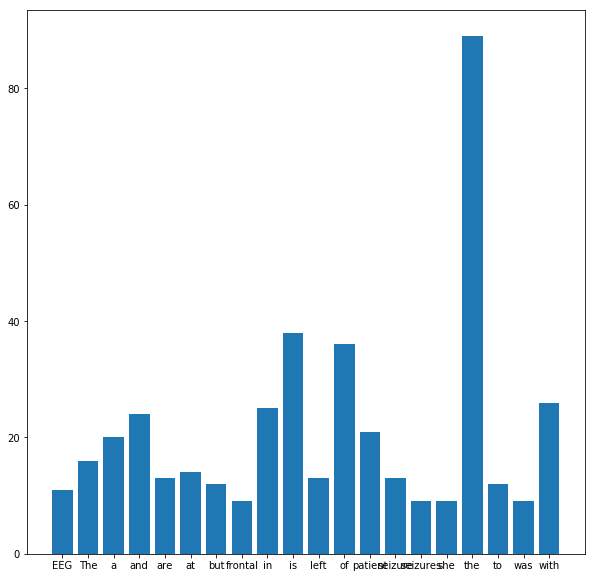

In [170]:
#fDist.most_common(30)
mostCommon = fDist.most_common(20)
xAxisVals = []
yAxisVals = []

plt.figure(figsize=(10,10))
for x in mostCommon:
    xAxisVals.append(x[0])
    yAxisVals.append(x[1])
plt.bar(xAxisVals,yAxisVals)
plt.show()

In [ ]:
'''with open(str(files),'r') as tseFile:
                    tseData = tseFile.readlines()  
                #tseData = tseData.split(' ')
                #print(files)
                #print('Something is wrong here, some of this isnt printing','\n')
                print('TSE DATA: ',tseData,'\n')
                print('Len: ',len(tseData),'\n')
                 for entry in tseData:
                        print('Entry Iteration: ',entry)
                        entryList = entry.split(' ')
                        #print("EntryList: ",entryList,"\n")
                        if len(entry)<4:
                            pass
                        else:
                            print("Found an entry",'\n')
                            print('currentEntry: ' ,entry)
                            currentT = currentFileSplit[2].split(".")
                            currentT = currentT[0]
                            tseEntry = {'segment':currentT,'startTime':entryList[0],'endTime':entryList[1],
                               'eventLabel':entryList[2],'probability':entryList[3]}
                            print("TSE ENTRY: ",tseEntry)
                            updateTseData.append(tseEntry)
                #print('TSE TYPE',type(tseData),'\n')
            
                try:
                    for entry in tseData:
                        print('Entry Iteration: ',entry)
                        entryList = entry.split(' ')
                        #print("EntryList: ",entryList,"\n")
                        if len(entry)<4:
                            pass
                        else:
                            print("Found an entry",'\n')
                            print('currentEntry: ' ,entry)
                            currentT = currentFileSplit[2].split(".")
                            currentT = currentT[0]
                            tseEntry = {'segment':currentT,'startTime':entryList[0],'endTime':entryList[1],
                               'eventLabel':entryList[2],'probability':entryList[3]}
                            print("TSE ENTRY: ",tseEntry)
                            updateTseData.append(tseEntry)
                    #tseEntry = {'startTime':tseData[0],'endTime':tseData[1],
                    #           'eventLabel':tseData[2],'probability':tseData[3]}
                except: 
                    print("Found and ERRRORRORORORO")
                    tseEntry='Error''''